# Enquete

Setup

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from IPython.core.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

local = True


if local:
  oefenFolder='../'
# else :
#   from google.colab import drive
#   drive.mount('/content/drive')
#
#   #vervang dit naar het pad in Google Drive waar jou datasets staan
#   !rm /content/oefeningen
#   !ln -s "/content/drive/Shareddrives/Data Science 1/2020-21/Lesmateriaal/5 centrum en spreiding/oefeningen" "/content/oefeningen"
#   !ls -la /content/oefeningen
#   oefenFolder='/content/oefeningen/'
#
#   #we moeten ook het script uitschieters.py kunnen importeren.
#   #daarom moeten we dit script in de folder "/content" copieren.
#   !cp "/content/drive/Shareddrives/Data Science 1/2020-21/Lesmateriaal/5 centrum en spreiding/oefeningen/oplossingen/uitschieters.py" /content/
#
# print('de folder met datasets = ' + oefenFolder + 'datasets/')

Importeer opnieuw de enquête dataset die je tijdens 'Data management' al gebruikt hebt

In [13]:
# importeer - Pas aan naar je eigen bestand
enquete_df = pd.read_csv(oefenFolder +'datasets/enquete/enquete202021.csv')

# Herhalen van opkuis-actie uit Datamanagement

vragen_df = pd.DataFrame(enquete_df.columns.to_numpy(), columns=['vraag'])
vragen_df.index = vragen_df.vraag.replace('(\\d{1,2}[a-z]?).*','v\\1', regex=True)
vragen_df = vragen_df\
    .replace('(\\d{1,2}[a-z]?)(.*)','\\2', regex=True)\
    .replace('[.]',' ', regex=True)\
    .replace('(^  )|( $)',' ',regex=True)
vragen_df
enquete_df.columns = vragen_df.index
enquete_df.drop(labels=['v28'], axis=1, inplace=True)
vragen_df.drop(labels=['v28'], inplace=True)

vragen_df.join(pd.DataFrame(enquete_df.dtypes, columns=['dtype']))
vragen_df.query('vraag.str.contains("letter")', engine='python')

enquete_df.v1b = enquete_df.v1b.str.upper()                       # alles omzetten naar uppercase
enquete_df.loc[~enquete_df.v1b.str.isalpha(),['v1b']] = pd.NA     # niet alfanumerieke inhoud omzetten naar NA-waarde

vragen_df.query('vraag.str.contains("bloedgroep")', engine='python')
enquete_df.v7a = enquete_df.v7a.astype(pd.CategoricalDtype(categories=enquete_df.v7a.unique()))


from datetime import timedelta

# omzetten naar nominale meetschaal
for column in ['v1b', 'v2', 'v3', 'v4', 'v7a', 'v7b', 'v10', 'v11', 'v21', 'v22', 'v25', 'v26']:
    enquete_df[column] = enquete_df[column].astype(
        pd.CategoricalDtype(categories=enquete_df[column].dropna().unique()))

# omzetten naar ordinale meetschaal
enquete_df.v13 = enquete_df.v13.astype(
    pd.CategoricalDtype(categories=['Niet', 'Weinig', 'Matig', 'Groot', 'Zeer Groot', 'Extreem'], ordered=True))

# timestamp parsen als datetime object
enquete_df.Timestamp = enquete_df.Timestamp.apply(pd.to_datetime, format='%Y/%m/%d %I:%M:%S %p %Z')

# v14: aantal uren gewerkt voor school parsen als timedelta object
enquete_df.v14 = enquete_df.v14.apply(
    lambda row: timedelta(hours=int(row.split(':')[0]), minutes=int(row.split(':')[1])))

# v17: opening horeca parsen als datetime (vb. 2021-06-30)
enquete_df.v17 = enquete_df.v17.apply(pd.to_datetime, format='%Y-%m-%d')

# v1a : scores op GapMinder omzetten naar floats
v1a = enquete_df.v1a.copy()  # kopie maken om SettingWithCopyWarning te vermijden

# v1a.name = 'v1a_bis'                  # nodig indien je wil joinen met origineel
# breuken 1/x en 1 op x omzetten naar percentages
breuken1 = ['{}/{}'.format(i, '\d\d') for i in np.arange(0, 14)]
breuken2 = ['{}\s?op\s?{}'.format(i, '\d\d') for i in np.arange(0, 14)]
percentages = ['{:.0f}%'.format(i) for i in np.round(np.arange(0, 14) / np.full(14, 13) * 100, 0)]

# vervang breuknotaties door percentagenotaties
v1a = v1a.replace(breuken1, percentages, regex=True).replace(breuken2, percentages, regex=True)

# zet alle percentages om naar floats of NaN
enquete_df.v1a = v1a.replace('(\d?\d)%.*', '\\1', regex=True).apply(pd.to_numeric, errors='coerce')

# v18 zakgeld omzetten naar floats
enquete_df.v18 = enquete_df.v18.str.extract('(\d+.?\d?)').apply(pd.to_numeric, errors='coerce')
enquete_df.v19 = enquete_df.v19.str.extract('(\d+.?\d?)').apply(pd.to_numeric, errors='coerce')

# v27 studiepunten omzetten naar gemiddelden
enquete_df.v27 = enquete_df.v27.replace('(\D*)(\d+)(-\d+)?.*', '\\2\\3', regex=True).str.split('-').apply(
    pd.to_numeric).apply(np.mean)

,vraag
vraag,
Timestamp,Timestamp
v1a,Wat was je score op de GapMinder test? Je hoe...
v1b,Wat is de eerste letter van de voornaam van j...
v2,In welke klasgroep zit je?
v3,Met welke hand schrijf je ?
v4,Wat is je geslacht?
v5,Wat is je schoenmaat?
v6a,Wat is je lichaamslengte (in cm)?
v6b,Wat is je gewicht (in kg)?


,vraag,dtype
vraag,,
Timestamp,Timestamp,object
v1a,Wat was je score op de GapMinder test? Je hoe...,object
v1b,Wat is de eerste letter van de voornaam van j...,object
v2,In welke klasgroep zit je?,object
v3,Met welke hand schrijf je ?,object
v4,Wat is je geslacht?,object
v5,Wat is je schoenmaat?,float64
v6a,Wat is je lichaamslengte (in cm)?,int64
v6b,Wat is je gewicht (in kg)?,float64


,vraag
vraag,
v1b,Wat is de eerste letter van de voornaam van j...


,vraag
vraag,
v7a,Wat is je bloedgroep: AB0?


1. Welke schoenmaat komt het meest voor?


In [14]:
vraag=vragen_df.query('vraag.str.contains("schoen")', engine='python')
enquete_df.v5.value_counts().sort_index()
enquete_df.v5.mode()

34.0     2
36.0     1
37.0     1
39.0     2
39.5     1
40.0     2
41.0     7
42.0    17
42.5     2
43.0    19
43.5     1
44.0    21
44.5     1
45.0    15
46.0     8
46.5     1
47.0     2
Name: v5, dtype: int64

0    44.0
dtype: float64

2. Welke vorm heeft de verdeling van schoenmaat?

43.077669902912625

43.0

44.0

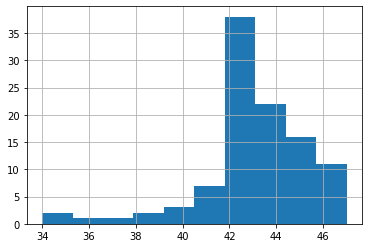

In [15]:
enquete_df.v5.mean()
enquete_df.v5.median()
enquete_df.v5.mode().to_numpy()[0]
_= enquete_df.v5.hist()
# Mean, median en modus liggen erg dicht bij elkaar
# Maar de modus is wel groter dan mean en median.
# Ook uit histogram blijkt dat de staart links uitloopt
# Dus => Links scheef

3. Zijn er uitschieters en of extreme uitschieters in de data mbt de schoenmaat?

42    37.0
46    34.0
57    36.0
70    34.0
Name: v5, dtype: float64

(37.875, 48.875)

0

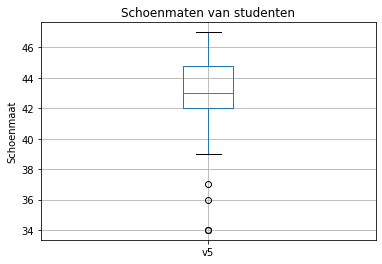

In [16]:
# we gebruiken opnieuw de functie outliers
from oefeningen.hulpfuncties import uitschieters
normal_outliers= enquete_df.v5[uitschieters(enquete_df.v5,mode='normaal')]
display(normal_outliers)
uitschieters(enquete_df.v5,output='grenzen')
#Er zijn 4 uitschieters onder de ondergrens van 37.875

extreme_outliers=enquete_df.v5[uitschieters(enquete_df.v5,mode='extreem')]
extreme_outliers.size
#Maar geen extreme uitschieters
fig,ax = plt.subplots()
_= enquete_df.boxplot(ax=ax,column=['v5'])
_ = ax.set_title('Schoenmaten van studenten')
_ = ax.set_ylabel('Schoenmaat')

4. Zijn er (evenveel) uitschieters in de data mbt de lengte?

,vraag
vraag,
v6a,Wat is je lichaamslengte (in cm)?


46    146
Name: v6a, dtype: int64

(160.0, 200.0)

0

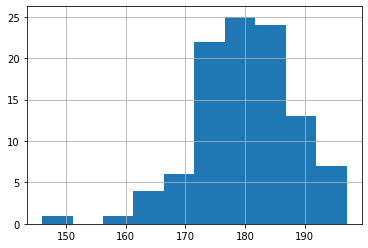

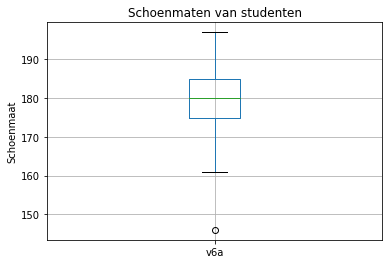

In [17]:
vragen_df.query('vraag.str.contains("lengte")', engine='python')
_ = enquete_df.v6a.hist()

from oefeningen.hulpfuncties import uitschieters
normal_outliers= enquete_df.v6a[uitschieters(enquete_df.v6a,mode='normaal')]
display(normal_outliers)
uitschieters(enquete_df.v6a,output='grenzen')
#Er is 1 uitschieter onder de ondergrens van 160

extreme_outliers=enquete_df.v6a[uitschieters(enquete_df.v6a,mode='extreem')]
extreme_outliers.size
#Maar geen extreme uitschieters
fig,ax = plt.subplots()
_= enquete_df.boxplot(ax=ax,column=['v6a'])
_ = ax.set_title('Schoenmaten van studenten')
_ = ax.set_ylabel('Schoenmaat')


5. Een student heeft als schoenmaat 44 en als lengte 175. Heeft deze student relatief (tov van de groep) gezien grotere voeten of een grotere lengte ?


In [18]:
#bereken de z-score
(175-enquete_df.v6a.mean()) / enquete_df.v6a.std()
(44-enquete_df.v5.mean()) / enquete_df.v5.std()
# beiden zijn een kleiner dan 1
# hun afwijking tov. het gemiddelde KLEINER is dat de standaard afwijking
# Dus => weinig afwijkend
# De lengte is een beetje lager dan het gemiddelde
# De schoenmaat is een beetje groter dan het gemiddelde

-0.6084767284312081

0.39580306921789254